<a href="https://colab.research.google.com/github/JeremySpradlin/DS17-Unit-2-Build-Project/blob/master/notebooks/Jeremy_Spradlin_DS17_Unit_2_Build_Project_Tuesday_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Sun Spots From Upper Atmosphere Radio Fluctuations

For this project, we will be combining multiple data sources to constuct a full data source that will allow us to predict the number of sunspots based on Radio Fluctuations in the upper atmosphere.

# Imports

In [48]:
#Installs
%%capture
import sys

!pip install category_encoders==2.*
!pip install eli5
!pip install pandas-profiling==2.*
!pip install pdpbox
!pip install shap

In [93]:
#Imports
%matplotlib inline

import pandas_profiling

import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LinearRegression, LogisticRegressionCV, LogisticRegression
from sklearn.impute import SimpleImputer

from xgboost import XGBClassifier

#Import our data sets

In [50]:
#Sun Spot Data
url1 = 'https://raw.githubusercontent.com/JeremySpradlin/DS-Unit-2-Build-Week/master/sunspot_data.csv'

#Earth Surface Temperatures
url2 = 'https://raw.githubusercontent.com/JeremySpradlin/DS-Unit-2-Build-Week/master/temperature_data.csv'

#Radio Flux
url3 = 'https://raw.githubusercontent.com/JeremySpradlin/DS-Unit-2-Build-Week/master/radio_flux.csv'

sspot = pd.read_csv(url1)
temp = pd.read_csv(url2)
flux = pd.read_csv(url3)

# Wrangling Functions

Below we will put in wrangle functions to clean up our data and prepare it for joining together.

In [51]:
#Sunspot Wrangle Function

def wrangle_sspots(df):
  """This function will take in a dataframe of Sunspot activity
  and perform different functions and actions on it to 
  prepare the dataset for training in a predictive model."""

  #Remove spaces from column names and change to lowercase
  df.columns = df.columns.str.lower().str.replace(' ', '_')

  #Replace -1's in target column
  df['number_of_sunspots'].replace(-1, np.NaN, inplace=True)

  #Remove observations with missing values or no observations
  df = df.dropna()
  mask = df[(df['observations'] == 0)].index
  df = df.drop(mask)

  #Create our datetime column
  df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

    #Remove columns
  df = df.drop(['indicator', 'unnamed:_0', 'year', 'month', 'day', 'date_in_fraction_of_year'], axis=1)

  #move the date column to the front
  col = df.pop('date')
  df.insert(0, 'date', col)

  #Reset Index
  df.reset_index(drop=True, inplace=True)

  return df

In [52]:
#Create our Wrangle Function for our temperature dataset
def wrangle_temp(df):
  """This dataset will take in our temperature data set, clean it, and prepare it for 
  easily joining with the other datasets"""

  #Drop the blank top row
  df.drop(index=0, inplace=True)

  #Fix our column names
  df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace(',', '')

  #Create our date column
  df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

  #move the date column to the front
  col = df.pop('date')
  df.insert(0, 'date', col)

  #Reset Index
  df.reset_index(drop=True, inplace=True)

  #Drop extra columns that are not needed
  df = df.drop(['date_number', 'year', 'month', 'day', 'day_of_year'], axis=1)

  return df

In [53]:
#Create our Wrangle function for our radio flux

def wrangle_flux(df):
  """ This function will take in the radio flux dataset and clean
  and adjust the data as needed for joining with the other datasets"""

  #Clean column names
  df = df.rename(columns={
    'year m': 'year',
    'onth': 'month',
  })

  #Create our date column
  df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

  #Drop extra columns
  df = df.drop(['year', 'month', 'day', 'cont_day'], axis=1)

  #move our date column to the front
  col = df.pop('date')
  df.insert(0, 'date', col)

  #Reset Index
  df.reset_index(drop=True, inplace=True)

  return df


# Cleaning and Joining our Datasets

In [54]:
#Clean our datasets
sspot = wrangle_sspots(sspot)
temp = wrangle_temp(temp)
flux = wrangle_flux(flux)

In [55]:
#Join our datasets into a single df that we can work with
df = pd.merge(sspot, temp, how='inner', on='date')
df = pd.merge(df, flux, how='inner', on='date')

df.head()

,date,number_of_sunspots,standard_deviation,observations,anomaly,f30,f30_c,f30_p,f30_f,f15,f15_c,f15_p,f15_f,f10.7,f10.7_c,f10.7_p,f10.7_f,f8,f8_c,f8_p,f8_f,f3.2,f3.2_c,f3.2_p,f3.2_f
0,1951-11-01,64.0,5.3,1,-1.914,71.4,71.4,1.9,2,87.6,87.6,2.5,2,107.3,107.3,3.6,0,110.6,110.6,3.1,2,288.9,288.9,3.5,2
1,1951-11-02,81.0,6.0,1,-2.271,70.3,70.3,1.9,2,85.6,85.6,2.5,2,104.7,104.7,3.6,0,108.3,108.3,3.1,2,287.1,287.1,3.5,2
2,1951-11-03,65.0,5.4,1,-1.389,69.5,69.5,1.9,2,84.7,84.7,2.5,2,106.1,106.1,3.6,2,107.7,107.7,3.0,2,287.0,287.0,3.5,2
3,1951-11-04,75.0,5.8,1,-0.913,66.8,66.8,1.9,2,81.1,81.1,2.5,2,107.2,107.2,3.6,0,105.3,105.3,3.0,2,286.8,286.8,3.5,2
4,1951-11-05,86.0,6.2,1,-0.900,71.8,71.8,1.9,2,88.4,88.4,2.5,2,114.0,114.0,3.6,0,111.3,111.3,3.0,2,288.1,288.1,3.5,2


In [56]:
df.shape

(24806, 25)

#Train Test Split

Below we will split our dataset into training/validation and testing sets.

In [57]:
#Create our train/test split function

def split(df):
  """This function will take in our dataset, strip off the time/date stamp,
  and split our dataset into different sets, stratifying on the number of sunspots"""

  #Drop our datetime column so we can use linear regression
  df = df.drop('date', axis=1)

  #Split our datasets into Training and testing sets
  train, test = train_test_split(df, train_size=0.8, test_size=0.2, random_state=42)

  #Now split our training set into Training and Validation sets
  train, val = train_test_split(train, train_size=0.8, test_size=0.2, random_state=42)

  return train, val, test




In [58]:
train, val, test = split(df)
train.shape, val.shape, test.shape

((15875, 24), (3969, 24), (4962, 24))

In [59]:
train.head()

,number_of_sunspots,standard_deviation,observations,anomaly,f30,f30_c,f30_p,f30_f,f15,f15_c,f15_p,f15_f,f10.7,f10.7_c,f10.7_p,f10.7_f,f8,f8_c,f8_p,f8_f,f3.2,f3.2_c,f3.2_p,f3.2_f
1241,0.0,0.0,1,-1.786,48.3,48.3,1.0,2,57.0,57.0,1.3,2,72.6,72.6,1.9,2,80.0,80.0,1.4,0,257.7,257.7,1.5,2
14949,183.0,6.7,10,-0.636,90.0,90.0,2.7,0,106.0,106.0,3.4,0,130.2,130.2,5.1,0,128.0,128.0,4.3,0,283.0,283.0,4.0,0
1278,31.0,3.8,1,0.296,53.1,53.1,1.1,2,63.9,63.9,1.3,2,79.8,79.8,1.9,0,84.0,84.0,1.4,0,253.5,253.5,1.4,2
2192,377.0,13.0,1,1.118,177.0,177.0,5.1,0,239.0,239.0,7.2,0,303.3,303.3,12.0,0,269.0,269.0,10.5,0,393.0,393.0,10.4,0
2295,251.0,10.6,1,-0.727,146.0,146.0,5.4,0,191.0,191.0,7.5,0,228.1,228.1,12.2,0,209.0,209.0,10.0,0,377.0,377.0,10.1,0


In [60]:
#Split our data into X and y sets
target = 'number_of_sunspots'

X_train = train.drop(columns=target)
y_train = train[target]

X_val = val.drop(columns=target)
y_val = val[target]

X_test = test.drop(columns=target)
y_test = test[target]

# Create our baseline

In [61]:
#Create our baseline and print out our target mean and MAE
guess = y_train.mean()
errors = guess - y_train
mae = errors.abs().mean()
print('Our target mean is', guess)
print('Our naive baseline MAE is', mae)

Our target mean is 91.89492913385827
Our naive baseline MAE is 67.80079793861772


# Create our initial pipeline


In [90]:
model = make_pipeline(
    StandardScaler(),
    SelectKBest(k=all),
    LinearRegression()
)

In [91]:
model.fit(X_train, y_train)

TypeError: ignored

In [64]:
#Check our accuracy on our different sets
print('Training Accuracy: ', model.score(X_train, y_train))
print('Validation Accuracy: ', model.score(X_val, y_val))

Training Accuracy:  0.9288605665538838
Validation Accuracy:  0.9330391150439348


In [73]:
print('Testing Accuracy: ', model.score(X_test, y_test))

Testing Accuracy:  0.9326259096319006


# Additional Model Exploration

Below we will play with and try additional models and metrics to evaluate and look at our permutation importance

In [78]:
#Try and get feature importances
lr = model.named_steps['linearregression']
importance = lr.coef_

print(importance)

[ 1.68867867e+01 -4.66565705e+00 -6.78963539e-01 -4.29722518e+02
  4.21356751e+02  2.53227374e+01 -1.96902618e+00  1.01224173e+03
 -9.83742266e+02 -5.83767156e+01  4.48925690e+00 -1.47826264e+02
  2.01307320e+02  1.08291825e+01 -1.17307063e-01 -8.20413138e+00
  3.16615887e+01  1.85395551e+00  1.30413237e-01 -1.99418444e+02
  1.68391768e+02  1.99244803e+01 -1.73749674e+00]


In [80]:
for i, v in enumerate(importance):
  print('Feature: %0d, Score: %.5f' % (i, v))

Feature: 0, Score: 16.88679
Feature: 1, Score: -4.66566
Feature: 2, Score: -0.67896
Feature: 3, Score: -429.72252
Feature: 4, Score: 421.35675
Feature: 5, Score: 25.32274
Feature: 6, Score: -1.96903
Feature: 7, Score: 1012.24173
Feature: 8, Score: -983.74227
Feature: 9, Score: -58.37672
Feature: 10, Score: 4.48926
Feature: 11, Score: -147.82626
Feature: 12, Score: 201.30732
Feature: 13, Score: 10.82918
Feature: 14, Score: -0.11731
Feature: 15, Score: -8.20413
Feature: 16, Score: 31.66159
Feature: 17, Score: 1.85396
Feature: 18, Score: 0.13041
Feature: 19, Score: -199.41844
Feature: 20, Score: 168.39177
Feature: 21, Score: 19.92448
Feature: 22, Score: -1.73750


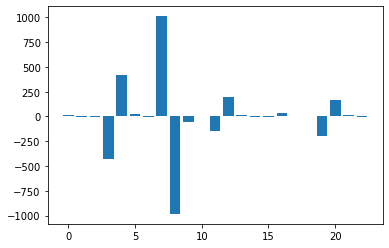

In [84]:
plt.bar([x for x in range(len(importance))], importance)

plt.show()

In [85]:
X_train.head()

,standard_deviation,observations,anomaly,f30,f30_c,f30_p,f30_f,f15,f15_c,f15_p,f15_f,f10.7,f10.7_c,f10.7_p,f10.7_f,f8,f8_c,f8_p,f8_f,f3.2,f3.2_c,f3.2_p,f3.2_f
1241,0.0,1,-1.786,48.3,48.3,1.0,2,57.0,57.0,1.3,2,72.6,72.6,1.9,2,80.0,80.0,1.4,0,257.7,257.7,1.5,2
14949,6.7,10,-0.636,90.0,90.0,2.7,0,106.0,106.0,3.4,0,130.2,130.2,5.1,0,128.0,128.0,4.3,0,283.0,283.0,4.0,0
1278,3.8,1,0.296,53.1,53.1,1.1,2,63.9,63.9,1.3,2,79.8,79.8,1.9,0,84.0,84.0,1.4,0,253.5,253.5,1.4,2
2192,13.0,1,1.118,177.0,177.0,5.1,0,239.0,239.0,7.2,0,303.3,303.3,12.0,0,269.0,269.0,10.5,0,393.0,393.0,10.4,0
2295,10.6,1,-0.727,146.0,146.0,5.4,0,191.0,191.0,7.5,0,228.1,228.1,12.2,0,209.0,209.0,10.0,0,377.0,377.0,10.1,0


In [86]:
X_train.shape

(15875, 23)

# Logistic Regression Model Attempt

In [94]:
log_model = make_pipeline(
    SimpleImputer(),
    LogisticRegression()
)

In [95]:
log_model.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [97]:
#Check our accuracy on our different sets
print('Training Accuracy: ', log_model.score(X_train, y_train))
print('Validation Accuracy: ', log_model.score(X_val, y_val))

Training Accuracy:  0.12963779527559055
Validation Accuracy:  0.13151927437641722


# Trying XGB

In [98]:
from sklearn.ensemble import GradientBoostingRegressor

In [99]:
gbmodel = make_pipeline(
    GradientBoostingRegressor(random_state=42)
)

In [101]:
gbmodel.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('gradientboostingregressor',
                 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                           criterion='friedman_mse', init=None,
                                           learning_rate=0.1, loss='ls',
                                           max_depth=3, max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=100,
                                           n_iter_no_change=None,
                                           presort='deprecated',
                                         

In [104]:
#Check our accuracy on our different sets
print('Training Accuracy: ', gbmodel.score(X_train, y_train))
print('Validation Accuracy: ', gbmodel.score(X_val, y_val))
print('Testing Accuracy: ', gbmodel.score(X_test, y_test))

Training Accuracy:  0.9587993557878448
Validation Accuracy:  0.9577668438236837
Testing Accuracy:  0.9575125062893188


In [105]:
#MAE 
guess = gbmodel.predict(X_test).mean()
errors = guess - y_test
mae = errors.abs().mean()

print(mae)

68.62116344237694


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Visuals for use in articles

In [ ]:
guess = y_train.mean()
errors = guess - y_train
mae = errors.abs().mean()